# Demonstração do algoritmo PROST

Esse notebook contém uma demonstração do algoritmo PROST para *tracking* de objetos. É possível controlar qual base de dados deve ser utilizada.

## Imports

A próxima célula realiza os imports necessários para execução do algoritmo.

In [1]:
import os
import shutil
from pathlib import Path

import cv2
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Video

from prost import FLOW, NCC, ORF, CC, PROST, MLP, Dataset, Matcher, MatchRect
from prost.core import compare_match

os.environ['PATH']

FPS = 30
SKIP_VIDEO = False

## Funções Utilitárias

Algumas funções utilitárias para simplificar a construção do Notebook.

In [2]:
def show(img: np.ndarray, gt_rect: MatchRect = None, rect: MatchRect = None):
    _, ax = plt.subplots()
    ax.imshow(img, cmap='gray')

    def maybe_draw(r: MatchRect, c='g'):
        if r is not None:
            x, y, w, h = r.as_bounding_rect()
            ax.add_patch(patches.Rectangle((x, y), w, h,
                                           linewidth=1,
                                           edgecolor=c,
                                           facecolor='none'))

    maybe_draw(gt_rect)
    maybe_draw(rect, 'b')


def get_template(img: np.ndarray, gt_rect: MatchRect):
    x, y, w, h = gt_rect.as_bounding_rect()
    return img[y:y+h, x:x+w]


def save_video_for_matcher(matcher: Matcher,
                           ds: Dataset,
                           output: str = 'tracking.mp4',
                           fps: int = 30):
    if SKIP_VIDEO:
        return

    dir = Path('tmp_imgs')
    if dir.exists():
        shutil.rmtree(dir)
    dir.mkdir(parents=False, exist_ok=False)

    def _write(index: int):
        sample = ds.get(index)
        img = cv2.cvtColor(sample[0].copy(),
                           cv2.COLOR_GRAY2RGB)

        if sample[1]:
            x, y, w, h = sample[1].as_bounding_rect()
            cv2.rectangle(img,
                          (x, y),
                          (x+w, y+h),
                          (0, 255, 0),
                          2)

        if index > 0:
            x, y, w, h = matcher.match(sample[0]).as_bounding_rect()
            cv2.rectangle(img,
                          (x, y),
                          (x+w, y+h),
                          (0, 0, 255),
                          2)

        fpath = dir.joinpath(f'{index:05d}.png')
        cv2.imwrite(str(fpath), img)

    for i in range(0, ds.n_images()):
        _write(i)

    if Path(output).exists():
        Path(output).unlink()
    os.system(f'ffmpeg -framerate {fps} '
              f'-i {dir}/%05d.png '
              '-movflags faststart '
              '-vcodec libx264 '
              '-pix_fmt yuv420p '
              '-hide_banner -loglevel error '
              f'{output}')
    shutil.rmtree(dir)

# Carregando Dataset

Todas as sequências de imagem utilizadas foram extraídas de https://web.archive.org/web/20140418040427/http://vision.ucsd.edu/~bbabenko/project_miltrack.shtml. Ao instanciar o dataset, os arquivos são baixados automaticamente (~400MB).

Todos os datasets considerados possuem *Ground Truth* para frames múltiplos de *5* (i.e., frame 0, 5, 10, 15, etc). Os demais frames não possuem GT. Nas imagens, o verde indica o GT e o azul a região predita pelo algoritmo. No caso dos vídeos, o vermelho indica a região predita.

In [3]:
Dataset.available_datasets()

['surfer',
 'david',
 'coke11',
 'faceocc',
 'tiger1',
 'faceocc2',
 'twinnings',
 'cliffbar',
 'girl',
 'tiger2',
 'dollar',
 'sylv']

In [4]:
ds = Dataset('sylv')
idx = 0
n_after = 100

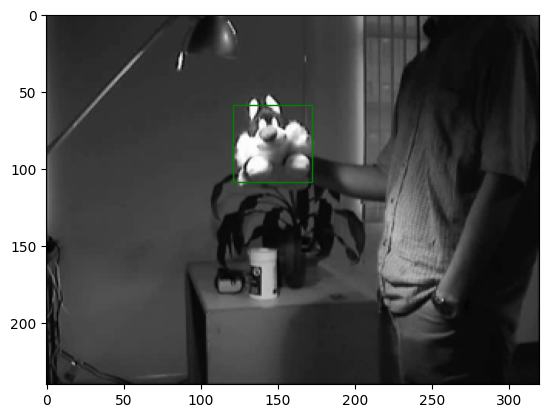

In [5]:
show(*ds.get(0))

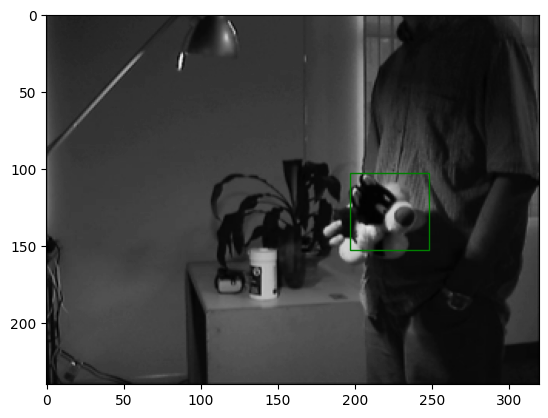

In [6]:
show(*ds.get(ds.end_idx()))

# Componente 1: NCC

Um dos componentes do PROST é o NCC (Normalized Cross Correlation), uma técnica de *Template Matching* que recebe um *template* como entrada e é capaz de fazer o *match* em imagens arbitrárias.

In [7]:
ncc = NCC(get_template(*ds.get(idx)))

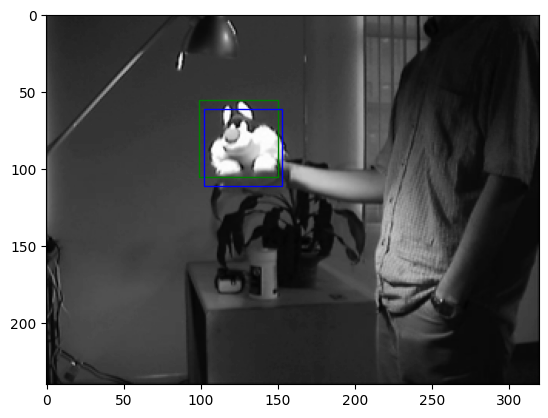

In [8]:
show(*compare_match(ds, ncc, idx + n_after))

In [9]:
save_video_for_matcher(ncc, ds, output='ncc.mp4', fps=FPS)
Video('ncc.mp4')

# Componente 2: FLOW

O 2º componente do PROST é um *tracker* baseado no Dense Optical Flow, recebendo como entrada o ROI e a imagem atual. O intuito é utilizar um procedimento mean shift com os *flow vectors* para atualizar o ROI a cada nova imagem recebida.

In [10]:
flow = FLOW(*ds.get(idx))

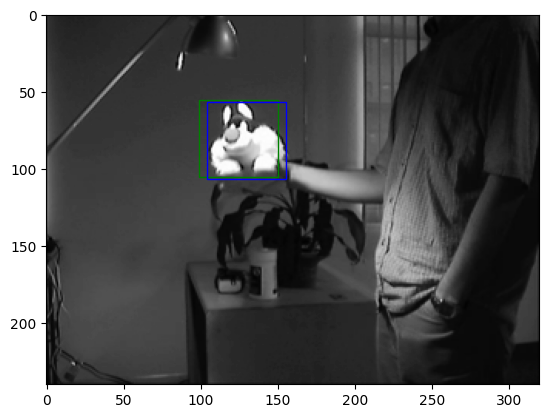

In [11]:
t = idx + n_after
for i in range(idx + 1, t):
    compare_match(ds, flow, i)
show(*compare_match(ds, flow, t))

In [12]:
save_video_for_matcher(flow, ds, output='flow.mp4', fps=FPS)
Video('flow.mp4')

# Componente 3: Online RF

O último componente do PROST é um *online cascading classifier* baseado no *Online Random Forest*. O treinamento é realizado com o *frame* atual e o *bounding rect* do NCC.

# Variante: Cascading Classifier para detecção de Objetos

# Variante: MLP para detecção de Objetos

In [13]:
mlp = MLP(*ds.get(idx), n_hidden=[1000, 500, 250], steps=250)
# orf = ORF(*ds.get(idx), quiet=True, bin_prefix='remote/build/bin/')

In [14]:
for i in range(0, 50, 5):
    mlp.train(*ds.get(idx))

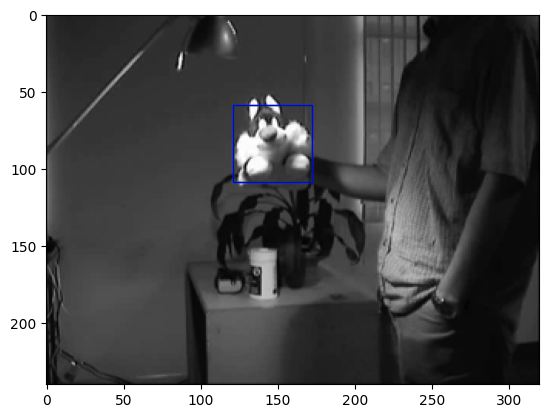

In [15]:
show(*compare_match(ds, mlp, idx))

In [16]:
save_video_for_matcher(mlp, ds, output='mlp.mp4', fps=FPS)
Video('mlp.mp4')

# Variante: CNN para detecção da Objetos

# PROST

Juntando todos os componentes.